In [1]:
!pip install tensorflow_addons

You should consider upgrading via the 'C:\ProgramData\Anaconda3\python.exe -m pip install --upgrade pip' command.


In [2]:
!pip install imblearn


You should consider upgrading via the 'C:\ProgramData\Anaconda3\python.exe -m pip install --upgrade pip' command.


In [3]:
!pip install neptune-notebooks

You should consider upgrading via the 'C:\ProgramData\Anaconda3\python.exe -m pip install --upgrade pip' command.


In [4]:
!jupyter nbextension enable --py neptune-notebooks

Enabling notebook extension neptune-notebooks/neptune-notebook...
      - Validating: ok


In [5]:
!pip install neptune-client

You should consider upgrading via the 'C:\ProgramData\Anaconda3\python.exe -m pip install --upgrade pip' command.


In [6]:
import neptune.new as neptune

run = neptune.init(project='blaisepke/AlzheimerPred',
                   api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJlYmViMmY2ZS1jNWFjLTRlMWMtYTdlOS00OGMxOWE0YTAzZDIifQ==') # your credentials



Info (NVML): NVML Shared Library Not Found. GPU usage metrics may not be reported. For more information, see https://docs-legacy.neptune.ai/logging-and-managing-experiment-results/logging-experiment-data.html#hardware-consumption 


https://app.neptune.ai/blaisepke/AlzheimerPred/e/AL-2
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [7]:
import pandas as pd
import numpy as np
import os
import sys
import logging
import matplotlib.pyplot as plt
from random import randint
import tensorflow as tf
from distutils.dir_util import copy_tree, remove_tree

from PIL import Image
from random import randint

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow_addons as tfa
from keras.utils.vis_utils import plot_model
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, MaxPool2D



print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.3.1


In [8]:
module_path =os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"\\scripts")

if module_path not in sys.path:
    sys.path.append(module_path+"\\model")



logging.basicConfig(filename='../logs/preprocessnotebook.log', filemode='w', format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',level=logging.DEBUG)

In [9]:
from load_data import PREP

In [10]:
load_Instance=PREP()
train_data_gen,classes=load_Instance.pre_process()

 ================ Folder found ================= 

 ==== Contents of train directory ========= 
 ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'] 

 ==== Contents of test directory ========= 
 ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'] 

================ Creating new working tree ================
========= Creating directory ========= 

 ============ new directory contains ======== 

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
Found 6400 images belonging to 4 classes.


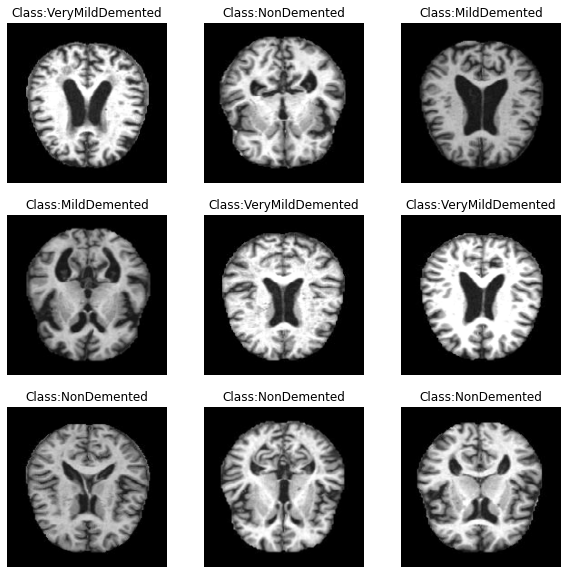

In [11]:
def show_images(generator,y_pred=None):
    """
    Input: An image generator,predicted labels (optional)
    Output: Displays a grid of 9 images with lables
    """
    
    # get image lables
    labels =dict(zip([0,1,2,3], classes))
    
    # get a batch of images
    x,y = generator.next()
    
    # display a grid of 9 images
    plt.figure(figsize=(10, 10))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            idx = randint(0, 6400)
            plt.imshow(x[idx])
            plt.axis("off")
            plt.title("Class:{}".format(labels[np.argmax(y[idx])]))
                                                     
    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))
    
# Display Train Images
show_images(train_data_gen)

In [12]:
train_data, train_labels = train_data_gen.next()

In [13]:
train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

In [14]:
from cnn import Network

cnnInstance=Network()
cnnInstance.build_network(X_train,X_test)

NameError: name 'X_train' is not defined

In [15]:
def conv_block(filters, act='relu'):
    """Defining a Convolutional NN block for a Sequential CNN model. """
    
    block = Sequential()
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(BatchNormalization())
    block.add(MaxPool2D())
    
    return block

def dense_block(units, dropout_rate, act='relu'):
    """Defining a Dense NN block for a Sequential CNN model. """
    
    block = Sequential()
    block.add(Dense(units, activation=act))
    block.add(BatchNormalization())
    block.add(Dropout(dropout_rate))
    
    return block

def construct_model(act='relu'):
    """Constructing a Sequential CNN architecture for performing the classification task. """
    
    model = Sequential([
        Input(shape=(*[176,176], 3)),
        Conv2D(16, 3, activation=act, padding='same'),
        Conv2D(16, 3, activation=act, padding='same'),
        MaxPool2D(),
        conv_block(32),
        conv_block(64),
        conv_block(128),
        Dropout(0.2),
        conv_block(256),
        Dropout(0.2),
        Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        Dense(4, activation='softmax')        
    ], name = "cnn_model")

    return model
#Defining a custom callback function to stop training our model when accuracy goes above 99%

class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_acc') > 0.99:
            print("\nReached accuracy threshold! Terminating training.")
            self.model.stop_training = True
            
my_callback = MyCallback()

#EarlyStopping callback to make sure model is always learning
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

In [16]:
#Defining other parameters for our CNN model

model = construct_model()

METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc'), 
           tfa.metrics.F1Score(num_classes=4)]

CALLBACKS = [my_callback]
    
model.compile(optimizer='adam',
              loss=tf.losses.CategoricalCrossentropy(),
              metrics=METRICS)

model.summary()

Model: "cnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 176, 176, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 176, 176, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 88, 88, 16)        0         
_________________________________________________________________
sequential (Sequential)      (None, 44, 44, 32)        14016     
_________________________________________________________________
sequential_1 (Sequential)    (None, 22, 22, 64)        55680     
_________________________________________________________________
sequential_2 (Sequential)    (None, 11, 11, 128)       221952    
_________________________________________________________________
dropout (Dropout)            (None, 11, 11, 128)       0 

In [ ]:
#Fit the training data to the model and validate it using the validation data
EPOCHS = 100

history = model.fit(train_data, train_labels, validation_data=(val_data, val_labels), callbacks=CALLBACKS, epochs=EPOCHS)
# run["MODEL"] = "CNN"
# run["parameters"] = {"learning_rate": 0.001,
#                      "optimizer": "Adam"}

for epoch in EPOCHS:
    run["train/loss"].log(history.history[metric])
   

Epoch 1/100
128/128 [==============================] - 483s 4s/step - loss: 1.7190 - acc: 0.3384 - auc: 0.5924 - f1_score: 0.2522 - val_loss: 4.5351 - val_acc: 0.5117 - val_auc: 0.6744 - val_f1_score: 0.1693
Epoch 2/100
128/128 [==============================] - 526s 4s/step - loss: 1.3083 - acc: 0.4478 - auc: 0.7130 - f1_score: 0.2989 - val_loss: 2.2337 - val_acc: 0.5107 - val_auc: 0.5924 - val_f1_score: 0.1703
Epoch 3/100
128/128 [==============================] - 482s 4s/step - loss: 1.1578 - acc: 0.4805 - auc: 0.7631 - f1_score: 0.3015 - val_loss: 1.8128 - val_acc: 0.5117 - val_auc: 0.7724 - val_f1_score: 0.1693
Epoch 4/100
128/128 [==============================] - 353s 3s/step - loss: 1.0540 - acc: 0.5061 - auc: 0.7964 - f1_score: 0.3186 - val_loss: 1.1564 - val_acc: 0.4609 - val_auc: 0.7291 - val_f1_score: 0.3352
Epoch 5/100
128/128 [==============================] - 339s 3s/step - loss: 0.9873 - acc: 0.5239 - auc: 0.8164 - f1_score: 0.3242 - val_loss: 1.3454 - val_acc: 0.5225 -